## Introduction

Baseado no Tutorial: https://thedatafrog.com/en/articles/overfitting-illustrated/

Imports e configurações iniciais:

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#configura a exibição de gráficos gerados com a biblioteca Matplotlib diretamente no notebook, em vez de abrir uma janela separada para cada gráfico.
%matplotlib inline

#especifica uma semente fixa para números aleatórios
np.random.seed(0xdeadbeef)


## Dataset Fictício

Classificação binária com duas entradas: x1 e x2.

Amostras da classe 0, são geradas com uma Gaussiana 2D centrada em (0,0) com "desvio padrão" 1.
Amostras da classe 1, são geradas com a Gaussiana centrada em (1,1).

In [4]:
def make_sample(nexamples, means=([0.,0.],[1.,1.]), sigma=1.):
    normal = np.random.multivariate_normal
    # squared width:
    s2 = sigma**2.
    # below, we provide the coordinates of the mean as
    # a first argument, and then the covariance matrix
    # which describes the width of the Gaussian along the
    # two directions.
    # we generate nexamples examples for each category
    sgx0 = normal(means[0], [[s2, 0.], [0.,s2]], nexamples)
    sgx1 = normal(means[1], [[s2, 0.], [0.,s2]], nexamples)
    # setting the labels for each category
    sgy0 = np.zeros((nexamples,))
    sgy1 = np.ones((nexamples,))
    sgx = np.concatenate([sgx0,sgx1])
    sgy = np.concatenate([sgy0,sgy1])
    return sgx, sgy

Conjunto de treino inicial pequeno (sgx, sgy) com 30 amostras, pra mostrar que poucos dados favorecem overfitting.

O conjunto de teste (tgx, tgy) tem 200 amostras.

In [5]:
sgx, sgy = make_sample(30)
tgx, tgy = make_sample(200)

Text(0, 0.5, 'x2')

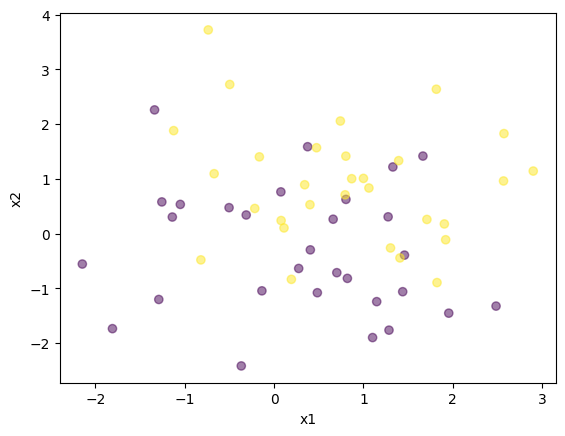

In [6]:
#Azul: Pontos da classe positiva
#Amarelo: Pontos da classe negativa

# plot do dataset pequeno, as cores são de acordo com a classe
plt.scatter(sgx[:,0], sgx[:,1], alpha=0.5, c=sgy)
plt.xlabel('x1')
plt.ylabel('x2')

Com tão poucos exemplos, nem fica aparente que são gerados por distribuições gaussianas e, além disso, não parece fácil separá-los.

## Overfitting

Vamos tentar classificar os dados com uma rede neural "complexa".
Ela é construida na celula abaixo, de acordo a biblioteca [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) com as seguintes características (pode ser customizado):

3 camadas ocultas de 50 neurônios cada.
Ativação ReLU nas camadas ocultas.
Otimizador Adam (uma variação sofisticada da descida de gradiente).

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

def get_scikit_mlp(data_x, data_y):
  #determina automaticamente a configuração da última camada
  mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp

Abaixo há duas funções para plotar os resultados.

As funções plotam os exemplos e uma probabilidade de cada ponto no espaço ser da classe 0 (branco) ou 1 (preto). Não se preocupe com esse código, apenas que ele recebe a rede treinada e os dados para mostrar.

In [8]:
def plot_result_scikit(model, data_x, data_y, linrange=(-5,5,101)):
    xmin, xmax, npoints = linrange
    gridx1, gridx2 = np.meshgrid(np.linspace(xmin,xmax,npoints), np.linspace(xmin,xmax,npoints))
    grid = np.c_[gridx1.flatten(), gridx2.flatten()]

    probs = model.predict_proba(grid)

    accuracy = accuracy_score(data_y, model.predict(data_x))
    print(f"Accuracy: {accuracy:.5f}")

    #print(probs)
    plt.pcolor(gridx1, gridx2, probs[:,1].reshape(npoints,npoints), cmap='binary')
    plt.colorbar()
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap='plasma', alpha=0.5, marker='.')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

Accuracy: 1.00000


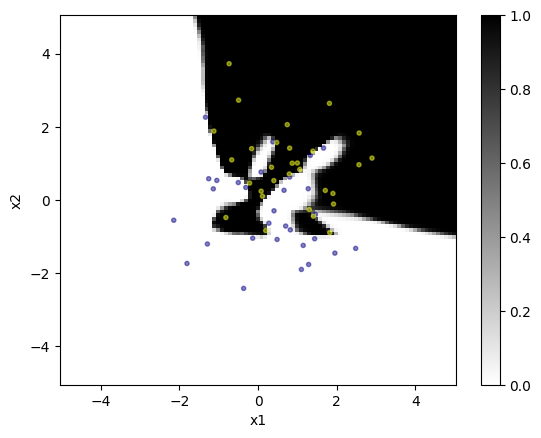

In [9]:
scikit_model = get_scikit_mlp(sgx, sgy)
plot_result_scikit(scikit_model, sgx,sgy)

Os pontos estão bem ajustados pela superfície de decisão. Porém, ela está longe de capturar a distribuição dos pontos (as gaussianas).


Vamos plotar para os dados de teste

Accuracy: 0.63750


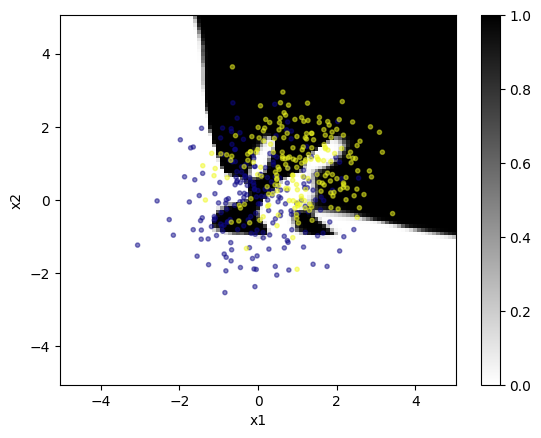

In [10]:
plot_result_scikit(scikit_model, tgx,tgy)

Muitos exemplos foram mal classificados. A rede foi muito bem no treino, e mal no teste.

**Isso é overfitting.**

## Testando uma rede menor

O código abaixo retorna uma rede de apenas uma camada oculta com 5 neurônios. A rede será treinada na amostra pequena e avaliada na amostra de teste.

In [11]:
def get_smaller_scikit_mlp(data_x, data_y):
  mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp

Accuracy: 0.72000


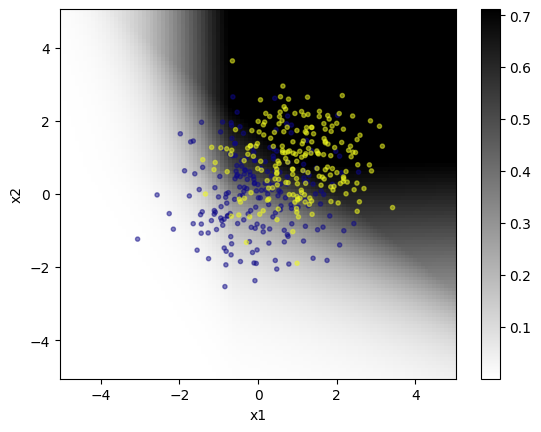

In [12]:
scikit_model = get_smaller_scikit_mlp(sgx, sgy)     # alternar pelas abaixo se usar keras
plot_result_scikit(scikit_model, tgx, tgy)

Agora, a rede não tem parâmetros suficientes para capturar a complexidade do conjunto de treinamento, e tenta encontrar um padrão geral.

Exercício: treinar as redes complexas em um conjunto de dados maior (preencha na celula abaixo). Qual o comportamento da rede com relação ao overfitting?

Accuracy: 0.76250


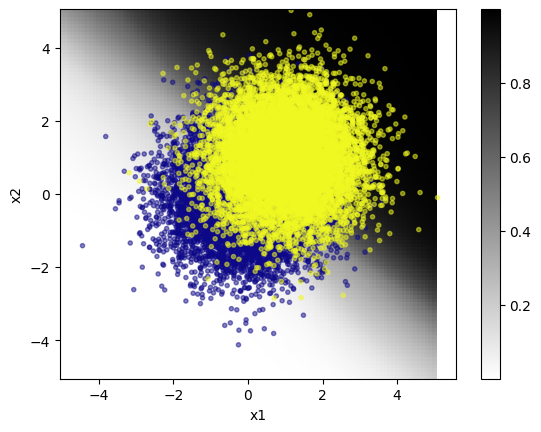

Accuracy: 0.76002


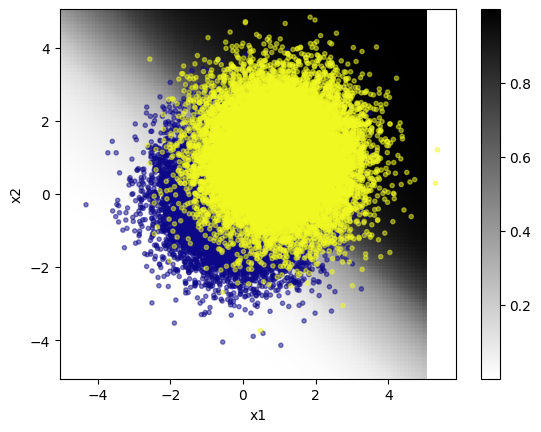

In [14]:
# use o make_sample para gerar 10000 amostras
sgx, sgy = make_sample(10000)
tgx, tgy = make_sample(20000)
# use a rede com 3 camadas ocultas de 50 neuronios cada
model = get_scikit_mlp(sgx, sgy)
# plote os resultados do modelo para os dados de teste (tgx e tgy)
plot_result_scikit(model, sgx, sgy)
plot_result_scikit(model, tgx, tgy)

## Redes complexas para dados complexos

Vamos construir um dataset complexo com 8 Gaussianas de dados, cada uma centrada em uma coordenada do espaço.

Cada chamada a make_sample cria 2 gaussianas, uma para cada classe, de acordo com as coordenadas especificadas.

In [15]:
sgxa, sgya = make_sample(100, ([0.,0],[1.,1.]), 0.3)
sgxb, sgyb = make_sample(100, ([3.,3],[4.,4.]), 0.3)
sgxc, sgyc = make_sample(100, ([5.,5.],[-2.,-2.]), 0.6)
sgxd, sgyd = make_sample(100, ([-1,3.],[3.,-1.]), 0.3)

data_x = np.concatenate([sgxa,sgxb,sgxc,sgxd])
data_y = np.concatenate([sgya,sgyb,sgyc,sgyd])

Text(0, 0.5, 'x2')

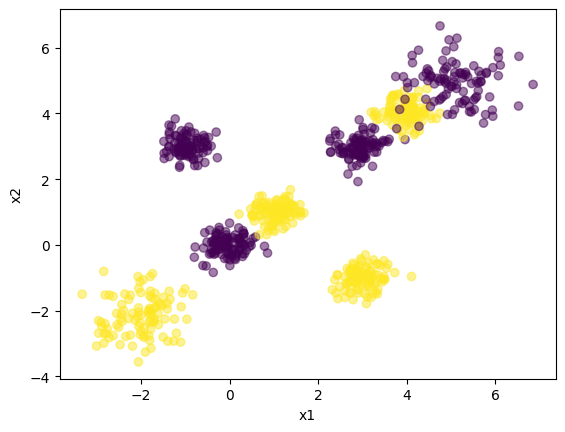

In [16]:
plt.scatter(data_x[:,0], data_x[:,1], alpha=0.5, c=data_y)
plt.xlabel('x1')
plt.ylabel('x2')

Uma rede pequena poderá classificar esses dados corretamente?
Segue abaixo o código com uma rede muito simples (1 camada oculta de 3 neuronios).


Accuracy: 0.67875


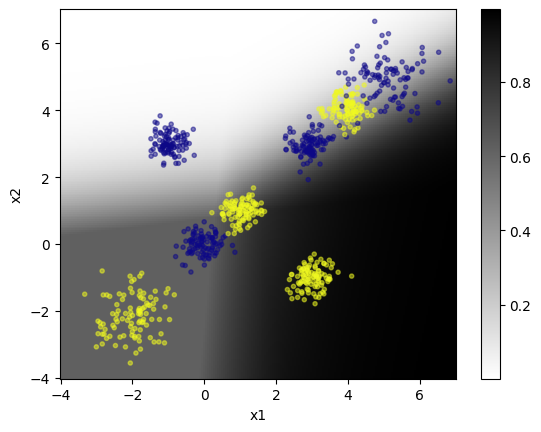

In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', max_iter=10000)
mlp.fit(data_x, data_y)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

A rede não tem parâmetros suficientes para se ajustar aos dados.

**Isso é underfitting.**

Vamos dar "poder preditivo" suficiente à rede, colocando 3 camadas ocultas de 50 neurônios cada:

Accuracy: 0.98750


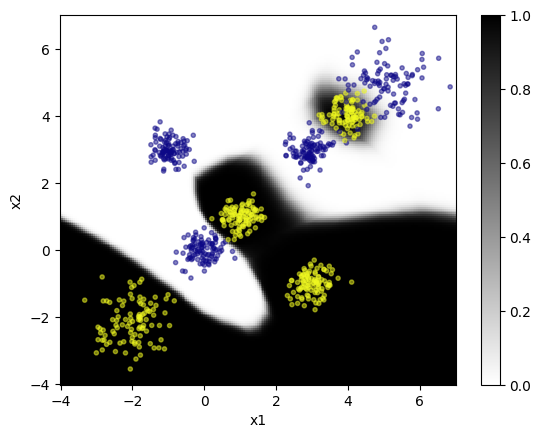

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000)
mlp.fit(data_x, data_y)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

Accuracy: 0.97188


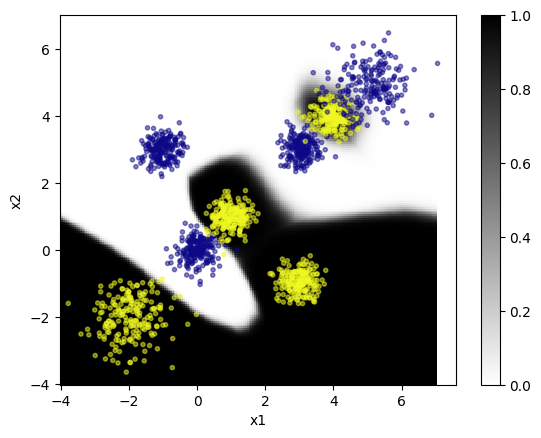

In [19]:
sgxa, sgya = make_sample(200, ([0.,0],[1.,1.]), 0.3)
sgxb, sgyb = make_sample(200, ([3.,3],[4.,4.]), 0.3)
sgxc, sgyc = make_sample(200, ([5.,5.],[-2.,-2.]), 0.6)
sgxd, sgyd = make_sample(200, ([-1,3.],[3.,-1.]), 0.3)

data_tx = np.concatenate([sgxa,sgxb,sgxc,sgxd])
data_ty = np.concatenate([sgya,sgyb,sgyc,sgyd])

plot_result_scikit(mlp, data_tx, data_ty,linrange=(-4,7,201))